## Building Mapping

In this tutorial, we are going to detect the buildings using satellite imagery. It is a binary class segmentation problem. 


### Dataset
The dataset is taken from [kaggle](https://www.kaggle.com/datasets/tekbahadurkshetri/building-mapping). Feel free to test and modify the code as your requirement.

Input data are RGB satellite images. And output are binary images. Pixel value is 0 for non-buildings and pixel value is 1 for buildings.



In [3]:
# import necessary libraries
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

## Data preprocessing

In [5]:
train_x = sorted(glob.glob('train/*_image.tif'))
train_y = sorted(glob.glob('train/*_label.tif'))
test_x = sorted(glob.glob('test/*_image.tif'))
test_y = sorted(glob.glob('test/*_label.tif'))

N_train = len(train_x)
N_test = len(test_x)

print(len(train_x), len(test_x))

336 84


In [6]:
# converting training image to numpy array
train_xx = np.zeros((N_train, 128, 128, 3))
train_yy = np.zeros((N_train, 128, 128, 1))
for i, (img, mask) in enumerate(zip(train_x, train_y)):
  # if i == 1:
  #   break
  
  img = Image.open(img)
  img = img.convert('RGB')
  np_img = np.array(img)
  train_xx[i] = np_img 

  mask = Image.open(mask)
  np_mask = np.array(mask).reshape(128, 128, 1)
  train_yy[i] = np_mask 

In [7]:
# converting testing image to numpy array
test_xx = np.zeros((N_test, 128, 128, 3))
test_yy = np.zeros((N_test, 128, 128, 1))
for i, (img, mask) in enumerate(zip(test_x, test_y)):
    
  img = Image.open(img)
  img = img.convert('RGB')
  np_img = np.array(img)
  test_xx[i] = np_img 

  mask = Image.open(mask)
  np_mask = np.array(mask).reshape(128, 128, 1)
  test_yy[i] = np_mask 

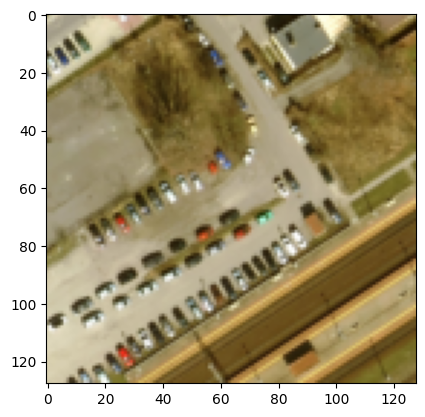

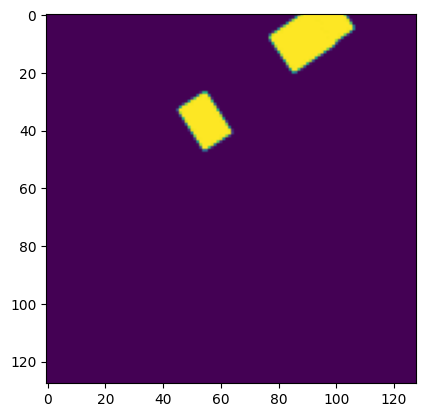

In [8]:
# Let's plot a sample input RGB image and output image with buildings

plt.imshow(train_xx[20, :, :, :].astype('uint8'))
plt.show()
plt.imshow(train_yy[20, :, :, 0].astype('uint8'))
plt.show()

## Save to numpy format

In [9]:
train_xx.shape

(336, 128, 128, 3)

In [10]:
np.save('train_xx.npy', train_xx)
np.save('train_yy.npy', train_yy)
np.save("test_xx.npy", test_xx)
np.save("test_yy.npy", test_yy)

## U-Net model development
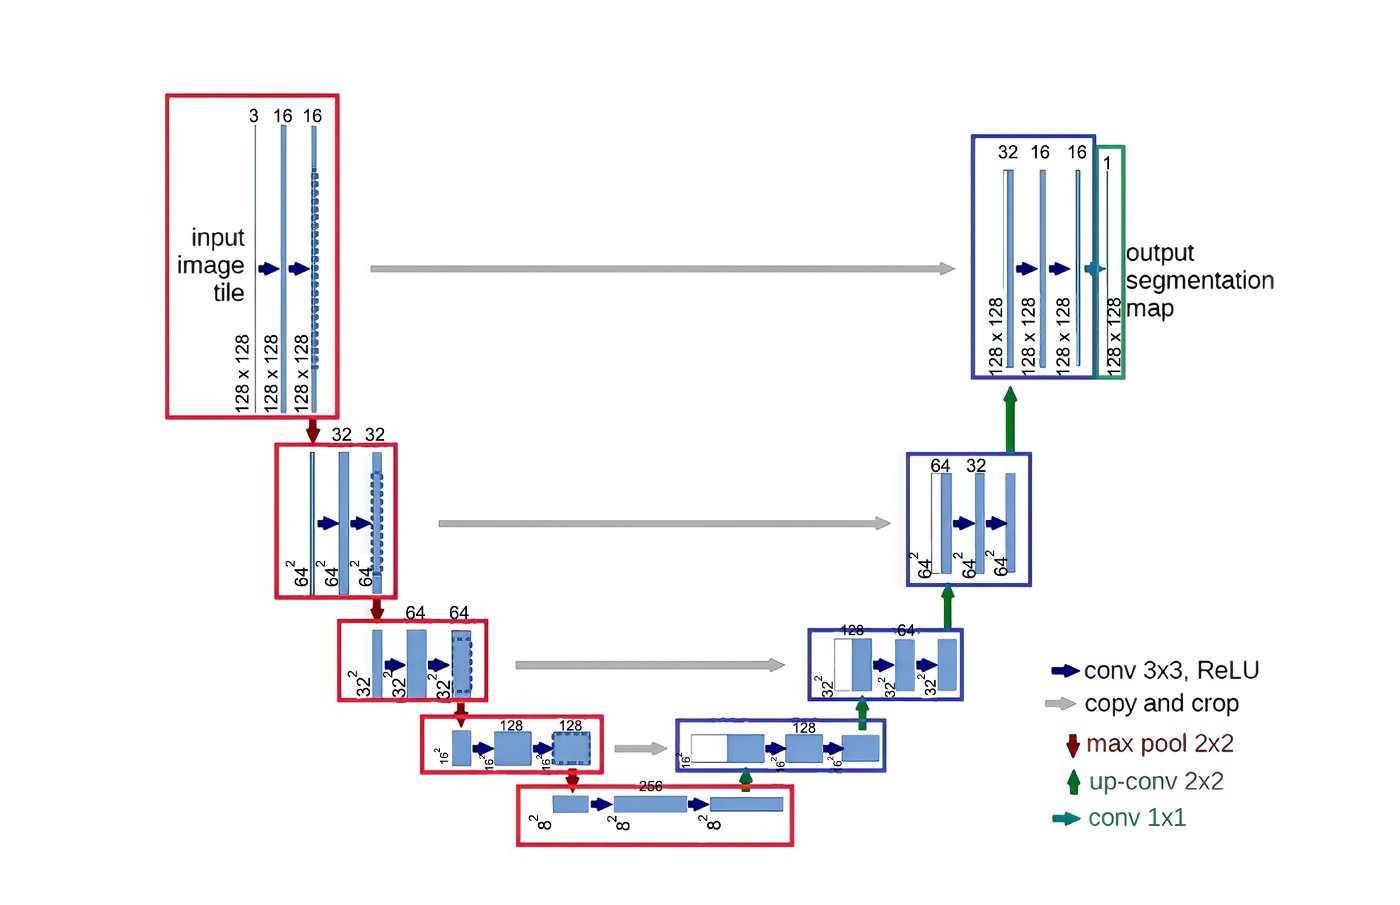


In [11]:
# Define U-Net model in PyTorch
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # Encoder
        self.enc1_1 = nn.Conv2d(3, 32, 3, padding=1)
        self.enc1_2 = nn.Conv2d(32, 32, 3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.drop1 = nn.Dropout2d(0.25)
        
        self.enc2_1 = nn.Conv2d(32, 32, 3, padding=1)
        self.enc2_2 = nn.Conv2d(32, 32, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.drop2 = nn.Dropout2d(0.25)
        
        self.enc3_1 = nn.Conv2d(32, 64, 3, padding=1)
        self.enc3_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.drop3 = nn.Dropout2d(0.25)
        
        # Bottom
        self.bottom1 = nn.Conv2d(64, 64, 3, padding=1)
        self.bottom2 = nn.Conv2d(64, 64, 3, padding=1)
        self.drop_bottom = nn.Dropout2d(0.5)
        
        # Decoder
        self.upconv3 = nn.ConvTranspose2d(64, 64, 3, padding=1)
        self.upconv3_2 = nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1)
        self.dec3_1 = nn.Conv2d(128, 64, 3, padding=1)  # 128 because of concatenation
        self.drop4 = nn.Dropout2d(0.5)
        
        self.upconv2 = nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1)
        self.dec2_1 = nn.Conv2d(96, 32, 3, padding=1)  # 96 because of concatenation
        self.drop5 = nn.Dropout2d(0.5)
        
        self.upconv1 = nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1)
        self.dec1_1 = nn.Conv2d(64, 32, 3, padding=1)  # 64 because of concatenation
        self.dec1_2 = nn.Conv2d(32, 32, 3, padding=1)
        self.drop6 = nn.Dropout2d(0.5)
        
        # Output
        self.out1 = nn.Conv2d(32, 32, 1)
        self.out2 = nn.Conv2d(32, 32, 1)
        self.out3 = nn.Conv2d(32, 1, 1)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Encoder
        x1 = self.relu(self.enc1_1(x))
        x1 = self.drop1(x1)
        x1 = self.relu(self.enc1_2(x1))
        p1 = self.pool1(x1)
        
        x2 = self.relu(self.enc2_1(p1))
        x2 = self.drop2(x2)
        x2 = self.relu(self.enc2_2(x2))
        p2 = self.pool2(x2)
        
        x3 = self.relu(self.enc3_1(p2))
        x3 = self.drop3(x3)
        x3 = self.relu(self.enc3_2(x3))
        p3 = self.pool3(x3)
        
        # Bottom
        b = self.relu(self.bottom1(p3))
        b = self.drop_bottom(b)
        b = self.relu(self.bottom2(b))
        
        # Decoder
        u3 = self.relu(self.upconv3(b))
        u3 = self.drop4(u3)
        u3 = self.relu(self.upconv3_2(u3))
        u3 = torch.cat([u3, x3], dim=1)
        d3 = self.relu(self.dec3_1(u3))
        d3 = self.drop4(d3)
        
        u2 = self.relu(self.upconv2(d3))
        u2 = torch.cat([u2, x2], dim=1)
        d2 = self.relu(self.dec2_1(u2))
        d2 = self.drop5(d2)
        
        u1 = self.relu(self.upconv1(d2))
        u1 = torch.cat([u1, x1], dim=1)
        d1 = self.relu(self.dec1_1(u1))
        d1 = self.drop6(d1)
        d1 = self.relu(self.dec1_2(d1))
        
        # Output
        out = self.relu(self.out1(d1))
        out = self.relu(self.out2(out))
        out = self.sigmoid(self.out3(out))
        
        return out

# Initialize model
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")

model = UNet().to(device)
print(model)

Using device: mps
UNet(
  (enc1_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc1_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout2d(p=0.25, inplace=False)
  (enc2_1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout2d(p=0.25, inplace=False)
  (enc3_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout2d(p=0.25, inplace=False)
  (bottom1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bottom2): Conv2d(64, 64, kernel_size=

In [12]:
# Prepare data for PyTorch (convert from HWC to CHW format)
# KLUCZOWA ZMIANA: Normalizacja danych do zakresu [0, 1]
print("Normalizowanie danych...")
print(f"Przed normalizacją - train_xx range: [{train_xx.min():.1f}, {train_xx.max():.1f}]")
print(f"Przed normalizacją - train_yy range: [{train_yy.min():.1f}, {train_yy.max():.1f}]")

train_xx_normalized = train_xx.astype('float32') / 255.0
test_xx_normalized = test_xx.astype('float32') / 255.0
train_yy_normalized = train_yy.astype('float32') / 255.0
test_yy_normalized = test_yy.astype('float32') / 255.0

print(f"Po normalizacji - train_xx range: [{train_xx_normalized.min():.3f}, {train_xx_normalized.max():.3f}]")
print(f"Po normalizacji - train_yy range: [{train_yy_normalized.min():.3f}, {train_yy_normalized.max():.3f}]")

train_xx_torch = torch.FloatTensor(train_xx_normalized).permute(0, 3, 1, 2)  # (N, 3, 128, 128)
train_yy_torch = torch.FloatTensor(train_yy_normalized).permute(0, 3, 1, 2)  # (N, 1, 128, 128)
test_xx_torch = torch.FloatTensor(test_xx_normalized).permute(0, 3, 1, 2)
test_yy_torch = torch.FloatTensor(test_yy_normalized).permute(0, 3, 1, 2)

print(f"\nKształty tensorów:")
print(f"train_xx_torch: {train_xx_torch.shape}")
print(f"train_yy_torch: {train_yy_torch.shape}")
print(f"test_xx_torch: {test_xx_torch.shape}")
print(f"test_yy_torch: {test_yy_torch.shape}")

# Create datasets and dataloaders
train_dataset = torch.utils.data.TensorDataset(train_xx_torch, train_yy_torch)
test_dataset = torch.utils.data.TensorDataset(test_xx_torch, test_yy_torch)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # Zwiększono batch_size
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define loss and optimizer
criterion = nn.BCELoss()  # Zmieniono na Binary Cross Entropy - lepsze dla segmentacji
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Dodano explicit learning rate

print(f"\n✓ Dane przygotowane do treningu")
print(f"  - Batch size: 16")
print(f"  - Train batches: {len(train_loader)}")
print(f"  - Test batches: {len(test_loader)}")
print(f"  - Loss function: BCELoss")
print(f"  - Learning rate: 0.001")

# Training loop
epochs = 100
train_losses = []
val_losses = []

print(f"\nRozpoczynanie treningu na {epochs} epok...")
print("=" * 60)

for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
    
    val_loss /= len(test_loader)
    val_losses.append(val_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

print("=" * 60)
print("✓ Training completed!")
print(f"Final Train Loss: {train_losses[-1]:.4f}")
print(f"Final Val Loss: {val_losses[-1]:.4f}")

Normalizowanie danych...
Przed normalizacją - train_xx range: [0.0, 255.0]
Przed normalizacją - train_yy range: [0.0, 255.0]
Po normalizacji - train_xx range: [0.000, 1.000]
Po normalizacji - train_yy range: [0.000, 1.000]

Kształty tensorów:
train_xx_torch: torch.Size([336, 3, 128, 128])
train_yy_torch: torch.Size([336, 1, 128, 128])
test_xx_torch: torch.Size([84, 3, 128, 128])
test_yy_torch: torch.Size([84, 1, 128, 128])

✓ Dane przygotowane do treningu
  - Batch size: 16
  - Train batches: 11
  - Test batches: 3
  - Loss function: BCELoss
  - Learning rate: 0.001

Rozpoczynanie treningu na 100 epok...
Epoch [10/100], Train Loss: 0.3714, Val Loss: 0.3753
Epoch [20/100], Train Loss: 0.2909, Val Loss: 0.2867
Epoch [30/100], Train Loss: 0.2516, Val Loss: 0.2468
Epoch [40/100], Train Loss: 0.2207, Val Loss: 0.2283
Epoch [50/100], Train Loss: 0.2031, Val Loss: 0.2113
Epoch [60/100], Train Loss: 0.1960, Val Loss: 0.2289
Epoch [70/100], Train Loss: 0.1917, Val Loss: 0.2083
Epoch [80/100], T

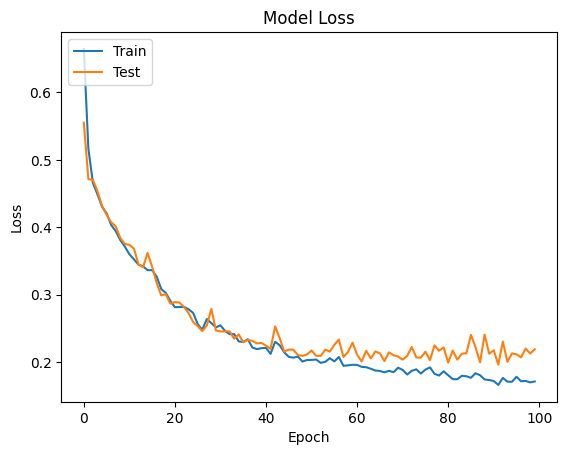

In [13]:
# plot model loss over training and validation data
plt.plot(train_losses)
plt.plot(val_losses)
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Prediction

(84, 1, 128, 128)


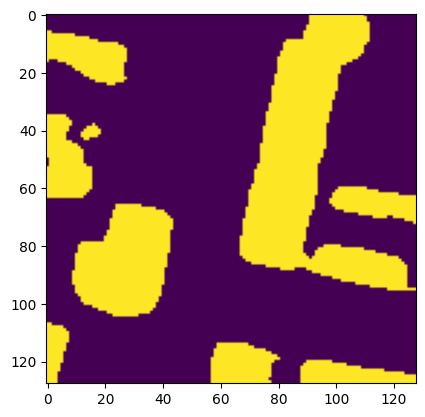

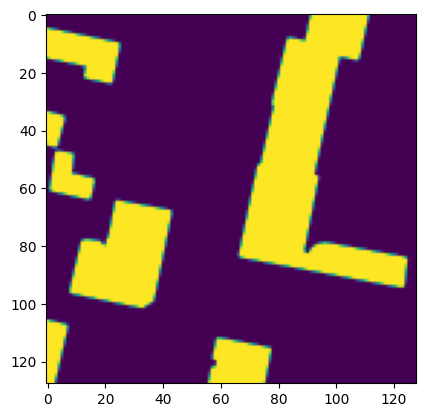

In [14]:
threshold = 0.5

# prediction of the output
model.eval()
with torch.no_grad():
    pred_test = model(test_xx_torch.to(device))
    pred_test = pred_test.cpu().numpy()
    pred_test = (pred_test > threshold).astype(np.uint8)

print(pred_test.shape)

# let's compare random predicted and actual y values 
plt.imshow(pred_test[10, 0, :, :])
plt.show()
plt.imshow(test_yy[10, :, :, 0])
plt.show()

This is not an operational model with high accuracy. But with more layers and with more data, we can develop this architecture in to an operational model with high accuracy.

## Convert numpy array to image

In [15]:
from PIL import Image
import os
def convert_numpy_array_to_img(in_npy, out_folder, channel=3):
    n = in_npy.shape[0]
    for i in range(n):
        if channel==3:
            image = Image.fromarray(in_npy[i].astype('uint8'))
            image.save(os.path.join(out_folder, f"{i}_image.tif"))
        
        else:
            image = Image.fromarray(in_npy[i, :, :, 0])
            image.save(os.path.join(out_folder, f"{i}_label.tif"))

In [16]:
# data is already randomized and split in to training / test sets. So we can go ahead and use them as it is.
x_train = np.load('train_xx.npy').astype('float32')
y_train= np.load('train_yy.npy').astype('float32')
x_test = np.load('test_xx.npy').astype('float32')
y_test = np.load('test_yy.npy').astype('float32') 

print("x_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("y_test shape", x_test.shape)
print("y_test shape", y_test.shape)

x_train shape (336, 128, 128, 3)
y_train shape (336, 128, 128, 1)
y_test shape (84, 128, 128, 3)
y_test shape (84, 128, 128, 1)


In [17]:
convert_numpy_array_to_img(x_train, 'train')
convert_numpy_array_to_img(y_train, 'train', channel=1)

convert_numpy_array_to_img(x_test, 'test')
convert_numpy_array_to_img(y_test, 'test', channel=1)

## Wykrywanie budynków w leszno.tiff

Przetwarzanie dużego obrazu przez dzielenie na kafelki 128x128

In [20]:
from PIL import Image
import numpy as np
import torch
from tqdm import tqdm

# Wczytaj duży obraz
print("Wczytywanie leszno.tiff...")
leszno_img = Image.open('leszno.tiff')
leszno_array = np.array(leszno_img)

print(f"Rozmiar obrazu: {leszno_array.shape}")
print(f"Typ danych: {leszno_array.dtype}")

# Jeśli obraz ma 4 kanały (RGBA), weź tylko RGB
if len(leszno_array.shape) == 3 and leszno_array.shape[2] == 4:
    leszno_array = leszno_array[:, :, :3]
    print("Przekonwertowano z RGBA na RGB")

# Jeśli obraz jest w skali szarości, przekonwertuj na RGB
if len(leszno_array.shape) == 2:
    leszno_array = np.stack([leszno_array] * 3, axis=-1)
    print("Przekonwertowano ze skali szarości na RGB")

Wczytywanie leszno.tiff...
Rozmiar obrazu: (3770, 11496, 3)
Typ danych: uint8


In [22]:
def process_large_image_in_tiles(image_array, model, tile_size=128, batch_size=16, overlap=0):
    """
    Przetwarza duży obraz przez dzielenie na kafelki i składanie wyniku.
    
    Args:
        image_array: numpy array (H, W, 3) - obraz w zakresie 0-255
        model: wytrenowany model PyTorch
        tile_size: rozmiar kafelka (128x128)
        batch_size: ile kafelków przetwarzać na raz
        overlap: nakładanie się kafelków (jeśli 0, brak nakładania)
    
    Returns:
        numpy array z maską budynków (H, W) w zakresie 0-1
    """
    h, w = image_array.shape[:2]
    stride = tile_size - overlap
    
    # Inicjalizuj pustą maskę wyniku
    result_mask = np.zeros((h, w), dtype=np.float32)
    count_mask = np.zeros((h, w), dtype=np.float32)  # do uśredniania nakładających się obszarów
    
    # Przygotuj kafelki
    tiles = []
    positions = []
    
    print("Tworzenie kafelków...")
    for y in range(0, h - tile_size + 1, stride):
        for x in range(0, w - tile_size + 1, stride):
            tile = image_array[y:y+tile_size, x:x+tile_size, :]
            
            # Sprawdź czy kafelek ma odpowiedni rozmiar
            if tile.shape[0] == tile_size and tile.shape[1] == tile_size:
                tiles.append(tile)
                positions.append((y, x))
    
    # Obsługa brzegów - dodaj kafelki na prawej i dolnej krawędzi jeśli potrzeba
    if (h - tile_size) % stride != 0:
        y = h - tile_size
        for x in range(0, w - tile_size + 1, stride):
            tile = image_array[y:y+tile_size, x:x+tile_size, :]
            if tile.shape[0] == tile_size and tile.shape[1] == tile_size:
                tiles.append(tile)
                positions.append((y, x))
    
    if (w - tile_size) % stride != 0:
        x = w - tile_size
        for y in range(0, h - tile_size + 1, stride):
            tile = image_array[y:y+tile_size, x:x+tile_size, :]
            if tile.shape[0] == tile_size and tile.shape[1] == tile_size:
                tiles.append(tile)
                positions.append((y, x))
    
    # Dodaj narożnik jeśli potrzeba
    if (h - tile_size) % stride != 0 and (w - tile_size) % stride != 0:
        y, x = h - tile_size, w - tile_size
        tile = image_array[y:y+tile_size, x:x+tile_size, :]
        tiles.append(tile)
        positions.append((y, x))
    
    print(f"Utworzono {len(tiles)} kafelków")
    
    # Przetwarzaj kafelki partiami
    model.eval()
    with torch.no_grad():
        for i in tqdm(range(0, len(tiles), batch_size), desc="Przetwarzanie kafelków"):
            batch_tiles = tiles[i:i+batch_size]
            batch_positions = positions[i:i+batch_size]
            
            # Konwertuj na tensor PyTorch i NORMALIZUJ do [0, 1]
            batch_array = np.array(batch_tiles).astype('float32') / 255.0
            batch_tensor = torch.FloatTensor(batch_array).permute(0, 3, 1, 2).to(device)
            
            # Predykcja
            predictions = model(batch_tensor)
            predictions = predictions.cpu().numpy()
            
            # Umieść wyniki w odpowiednich pozycjach
            for pred, (y, x) in zip(predictions, batch_positions):
                pred_mask = pred[0]  # usuń wymiar kanału
                result_mask[y:y+tile_size, x:x+tile_size] += pred_mask
                count_mask[y:y+tile_size, x:x+tile_size] += 1
    
    # Uśrednij nakładające się obszary
    result_mask = np.divide(result_mask, count_mask, where=count_mask>0)
    
    return result_mask

print("Funkcja do przetwarzania dużych obrazów gotowa!")

Funkcja do przetwarzania dużych obrazów gotowa!


In [23]:
# Przetwórz obraz leszno.tiff
print("Rozpoczynam wykrywanie budynków w leszno.tiff...")
print("To może potrwać kilka minut w zależności od rozmiaru obrazu...\n")

# Przetwórz obraz z niewielkim nakładaniem kafelków dla lepszych wyników na brzegach
leszno_mask = process_large_image_in_tiles(
    leszno_array, 
    model, 
    tile_size=128, 
    batch_size=16,  # zmniejsz jeśli brakuje pamięci
    overlap=16  # 16 pikseli nakładania dla lepszych wyników
)

print(f"\nWykrywanie zakończone! Rozmiar maski: {leszno_mask.shape}")

Rozpoczynam wykrywanie budynków w leszno.tiff...
To może potrwać kilka minut w zależności od rozmiaru obrazu...

Tworzenie kafelków...
Utworzono 3502 kafelków


Przetwarzanie kafelków: 100%|██████████| 219/219 [00:07<00:00, 30.27it/s]


Wykrywanie zakończone! Rozmiar maski: (3770, 11496)



Statystyki wykrywania budynków:
Całkowita liczba pikseli: 43,339,920
Piksele oznaczone jako budynki: 105,030
Procent powierzchni z budynkami: 0.24%


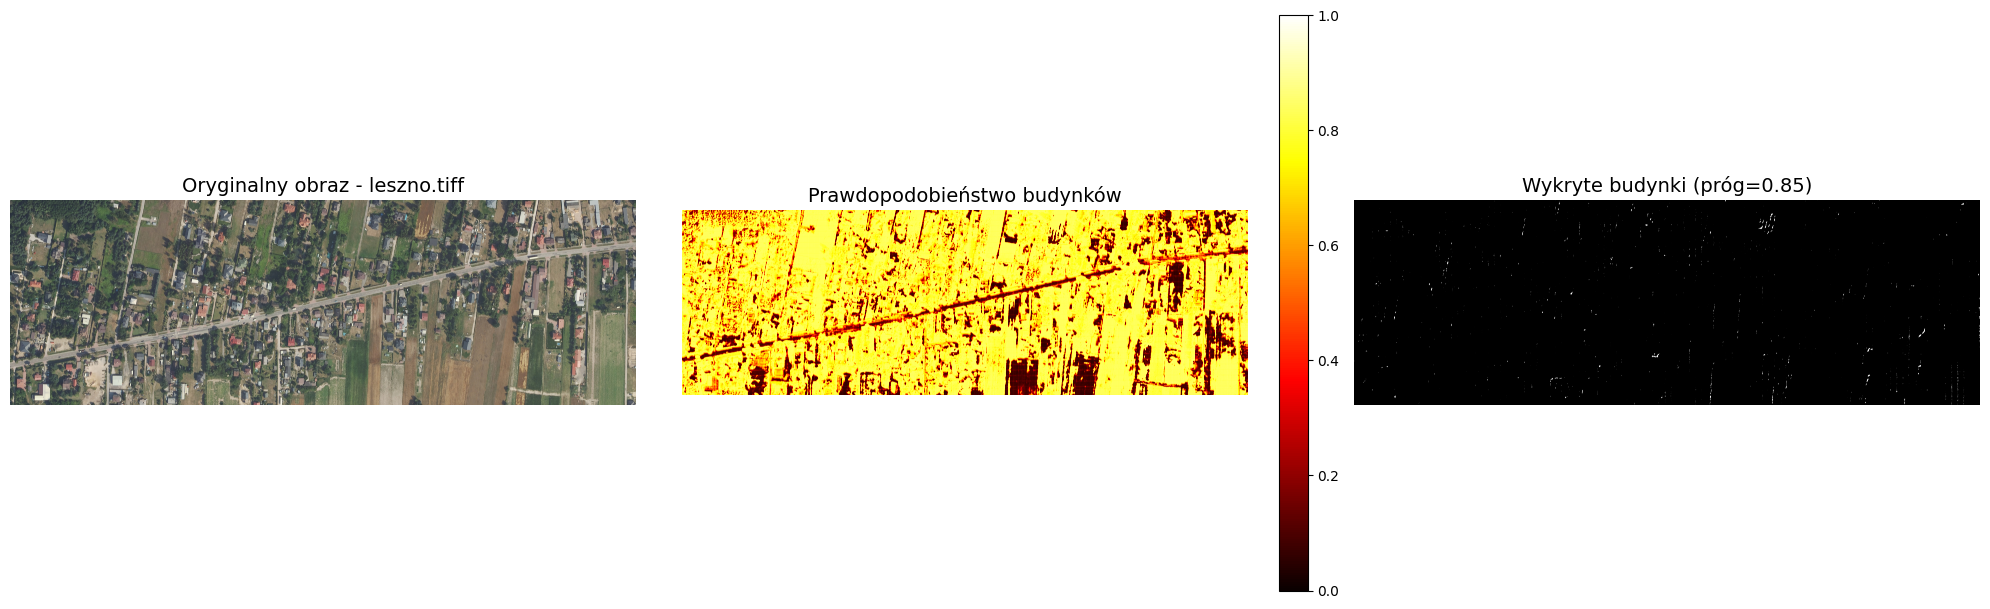

In [24]:
# Zastosuj próg i wizualizuj wyniki
threshold = 0.85
leszno_mask_binary = (leszno_mask > threshold).astype(np.uint8)

# Oblicz statystyki
total_pixels = leszno_mask_binary.size
building_pixels = np.sum(leszno_mask_binary)
building_percentage = (building_pixels / total_pixels) * 100

print(f"\nStatystyki wykrywania budynków:")
print(f"Całkowita liczba pikseli: {total_pixels:,}")
print(f"Piksele oznaczone jako budynki: {building_pixels:,}")
print(f"Procent powierzchni z budynkami: {building_percentage:.2f}%")

# Wizualizacja
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

# Oryginalny obraz
axes[0].imshow(leszno_array.astype('uint8'))
axes[0].set_title('Oryginalny obraz - leszno.tiff', fontsize=14)
axes[0].axis('off')

# Maska ciągła (prawdopodobieństwa)
im1 = axes[1].imshow(leszno_mask, cmap='hot', vmin=0, vmax=1)
axes[1].set_title('Prawdopodobieństwo budynków', fontsize=14)
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], fraction=0.046)

# Maska binarna
axes[2].imshow(leszno_mask_binary, cmap='gray')
axes[2].set_title(f'Wykryte budynki (próg={threshold})', fontsize=14)
axes[2].axis('off')

plt.tight_layout()
plt.show()

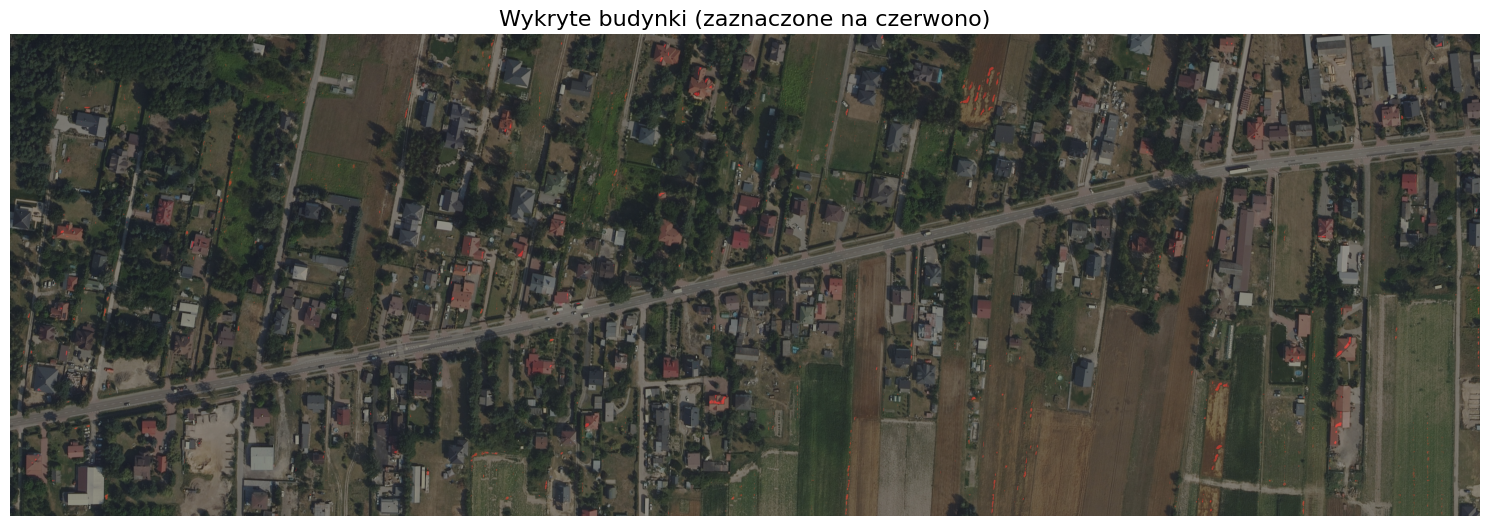

In [25]:
# Nałóż maskę na oryginalny obraz (podświetl budynki)
overlay = leszno_array.copy().astype(np.float32)

# Stwórz kolorową maskę (czerwony dla budynków)
red_mask = np.zeros_like(overlay)
red_mask[:, :, 0] = leszno_mask_binary * 255  # czerwony kanał

# Zmieszaj oryginał z maską (alfa blending)
alpha = 0.4  # przezroczystość maski
overlay_result = ((1 - alpha) * overlay + alpha * red_mask).astype(np.uint8)

# Wizualizacja
plt.figure(figsize=(15, 10))
plt.imshow(overlay_result)
plt.title('Wykryte budynki (zaznaczone na czerwono)', fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

In [26]:
# Zapisz wyniki do plików
print("Zapisywanie wyników...")

# Zapisz maskę binarną
mask_img = Image.fromarray((leszno_mask_binary * 255).astype(np.uint8))
mask_img.save('leszno_buildings_mask.tiff')
print("✓ Zapisano maskę binarną: leszno_buildings_mask.tiff")

# Zapisz maskę prawdopodobieństw (0-255)
prob_mask_img = Image.fromarray((leszno_mask * 255).astype(np.uint8))
prob_mask_img.save('leszno_buildings_probability.tiff')
print("✓ Zapisano maskę prawdopodobieństw: leszno_buildings_probability.tiff")

# Zapisz wizualizację z nałożonymi budynkami
overlay_img = Image.fromarray(overlay_result)
overlay_img.save('leszno_buildings_overlay.tiff')
print("✓ Zapisano wizualizację z nałożeniem: leszno_buildings_overlay.tiff")

print("\nWszystkie wyniki zapisane!")

Zapisywanie wyników...
✓ Zapisano maskę binarną: leszno_buildings_mask.tiff
✓ Zapisano maskę prawdopodobieństw: leszno_buildings_probability.tiff
✓ Zapisano wizualizację z nałożeniem: leszno_buildings_overlay.tiff

Wszystkie wyniki zapisane!


## Zapisz wytrenowany model

In [ ]:
# Zapisz model do pliku
model_path = 'unet_building_detection.pth'

# Zapisz pełny model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'epochs': epochs,
    'model_architecture': 'UNet',
}, model_path)

print(f"✓ Model zapisany do: {model_path}")
print(f"  - Wagi modelu")
print(f"  - Stan optymalizatora")
print(f"  - Historia treningu ({len(train_losses)} epok)")
print(f"\nRozmiar pliku: {os.path.getsize(model_path) / (1024*1024):.2f} MB")

✓ Model zapisany do: unet_building_detection.pth
  - Wagi modelu
  - Stan optymalizatora
  - Historia treningu (100 epok)

Rozmiar pliku: 4.73 MB
